In [ ]:
import os
# os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam


import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# Function to load files from a directory
def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as file_content:
                    file_text = file_content.read()
                file_list.append(file_text)
    return file_list
# Load training and test files for vulnerable and non-vulnerable classes
def load_data():
    dataset_dir = '/home/shaurya/BTP/1/Dataset/Code/C'
    vulnerable_dir = os.path.join(dataset_dir, 'Vulnerable')
    non_vulnerable_dir = os.path.join(dataset_dir, 'Non_vulnerable')

    vulnerable_train_files = load_files(os.path.join(vulnerable_dir, 'TRAIN'))
    vulnerable_test_files = load_files(os.path.join(vulnerable_dir, 'TEST'))
    non_vulnerable_train_files = load_files(os.path.join(non_vulnerable_dir, 'TRAIN'))
    non_vulnerable_test_files = load_files(os.path.join(non_vulnerable_dir, 'TEST'))

    train_codes = vulnerable_train_files + non_vulnerable_train_files
    test_codes = vulnerable_test_files + non_vulnerable_test_files

    labels = np.concatenate((np.ones(len(vulnerable_train_files)), np.zeros(len(non_vulnerable_train_files))), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(train_codes, labels, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, test_codes


def tokenize_sequences(X_train, X_test, test_codes):
    tokenizer = Tokenizer(num_words=359414, split=' ')
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    test_sequences = tokenizer.texts_to_sequences(test_codes)

    average_sequence_length = int(np.mean([len(seq) for seq in X_train_sequences]))

    X_train_padded = pad_sequences(X_train_sequences, maxlen=average_sequence_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=average_sequence_length)
    test_padded = pad_sequences(test_sequences, maxlen=average_sequence_length)

    return X_train_padded, X_test_padded, test_padded, tokenizer.word_index


def load_embedding_model():
    with open('/home/shaurya/BTP/1/Outputs/Embedding Models/Word2vec/word2vec_150_model.pkl', 'rb') as f:
        embedding_model = pickle.load(f)

    return embedding_model

def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='BLSTM_W2V_EL'))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), name='BLSTM_W2V_1'))
    model.add(Bidirectional(LSTM(units=128), name='BLSTM_W2V_2'))
    model.add(Dense(units=1, activation='sigmoid', name='BLSTM_W2V_OL'))
    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model




def perform_cross_validation(X_train_padded, y_train, model, skf):
    fold = 1
    accuracies = []

    for train_index, val_index in skf.split(X_train_padded, y_train):
        print(f"Fold: {fold}")
        fold += 1

        X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        checkpoint_path = f"/home/shaurya/BTP/1/Outputs/Checkpoints/Sentence/BILSTM/Word2vec/model10k_fold_{fold}.h5"
        checkpoint = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=False
        )

        history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop, checkpoint])
        
        plt.figure(figsize=(10, 5))  # Adjust figure size as desired
        plt.subplot(1, 2, 1)  # Create subplot for loss
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.subplot(1, 2, 2)  # Create subplot for accuracy
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

        _, accuracy = model.evaluate(X_val_fold, y_val_fold)
        accuracies.append(accuracy)

    return accuracies

    
def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)
    y_pred = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    print(report)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"/home/shaurya/BTP/1/Outputs/Checkpoints/Sentence/BILSTM/Word2vec/model10k_fold_{fold}.h5")


# Load the data
X_train, X_test, y_train, y_test, test_codes = load_data()

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

# Load the Word2Vec embedding model
embedding_model = load_embedding_model()

# Create the embedding matrix
embedding_dim = 150
vocab_size = 359414
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size and word in embedding_model.wv:
        embedding_matrix[i] = embedding_model.wv[word]

# Create a sequential model
model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])

# Create an early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Create Stratified K-fold cross-validation object
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Perform cross-validation training and collect accuracies
accuracies = perform_cross_validation(X_train_padded, y_train, model, skf)

# Print accuracy for each fold
for fold, accuracy in enumerate(accuracies, start=1):
    print(f"Accuracy for Fold {fold}: {accuracy}")

# Calculate and print average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")

# Evaluate the model using the test set
evaluate_model(X_test_padded, y_test, model)

# Predict on the additional test set
test_pred = predict_additional_data(test_padded, model)

# Save the trained model for each fold
for fold in range(1, skf.n_splits + 1):
    save_model(model, fold)
    
    
model.save(f"/home/shaurya/BTP/1/Outputs/Models/LSTM/word2vec/BLSTM_w2v.keras")


2024-03-26 08:31:15.335258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 08:31:15.591909: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 08:31:16.505370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-26 08:31:16.505495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

# FastText

2024-03-11 10:08:39.429282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 10:08:39.635411: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 10:08:40.440491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-11 10:08:40.440598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

DEBUG:tensorflow:Layer lstm will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_1 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_1 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_1 will use cuDNN kernels when running on GPU.
Fold: 1
Epoch 1/10


2024-03-11 10:08:55.830420: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


64/64 [==============================] - 27s 405ms/step - loss: 0.3042 - accuracy: 0.8858 - val_loss: 0.1483 - val_accuracy: 0.9644
Epoch 2/10
64/64 [==============================] - 26s 409ms/step - loss: 0.1525 - accuracy: 0.9451 - val_loss: 0.1392 - val_accuracy: 0.9556
Epoch 3/10
64/64 [==============================] - 26s 408ms/step - loss: 0.0859 - accuracy: 0.9713 - val_loss: 0.1239 - val_accuracy: 0.9556
Epoch 4/10
64/64 [==============================] - 26s 405ms/step - loss: 0.0606 - accuracy: 0.9802 - val_loss: 0.1529 - val_accuracy: 0.9600
Epoch 5/10
64/64 [==============================] - 26s 406ms/step - loss: 0.0418 - accuracy: 0.9881 - val_loss: 0.1680 - val_accuracy: 0.9378
Epoch 6/10
64/64 [==============================] - 26s 414ms/step - loss: 0.0337 - accuracy: 0.9916 - val_loss: 0.1091 - val_accuracy: 0.9733
Epoch 7/10
64/64 [==============================] - 26s 412ms/step - loss: 0.0117 - accuracy: 0.9985 - val_loss: 0.1028 - val_accuracy: 0.9778
Epoch 8/10

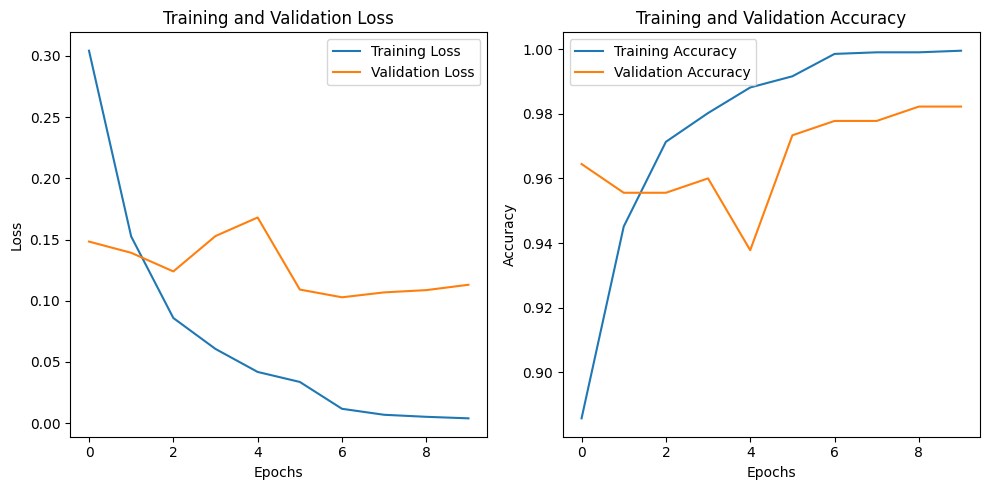

8/8 [==============================] - 1s 172ms/step - loss: 0.1131 - accuracy: 0.9822
Fold: 2
Epoch 1/10
64/64 [==============================] - 27s 415ms/step - loss: 0.0343 - accuracy: 0.9901 - val_loss: 0.0238 - val_accuracy: 0.9867
Epoch 2/10
64/64 [==============================] - 26s 413ms/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.0176 - val_accuracy: 0.9911
Epoch 3/10
64/64 [==============================] - 26s 407ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.0404 - val_accuracy: 0.9911
Epoch 4/10
64/64 [==============================] - 26s 406ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0230 - val_accuracy: 0.9911
Epoch 5/10
64/64 [==============================] - 26s 407ms/step - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.0319 - val_accuracy: 0.9911


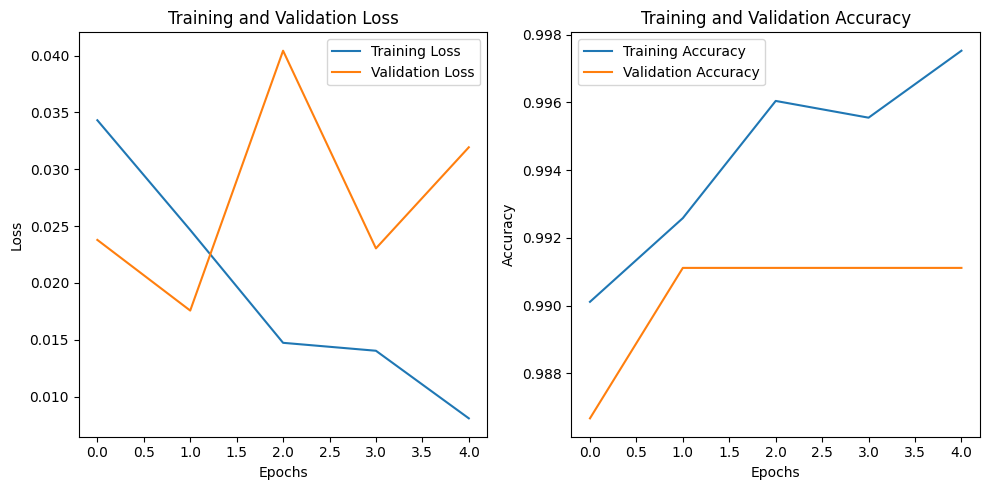

8/8 [==============================] - 1s 175ms/step - loss: 0.0319 - accuracy: 0.9911
Fold: 3
Epoch 1/10
64/64 [==============================] - 26s 414ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 27s 416ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 27s 415ms/step - loss: 9.5669e-04 - accuracy: 0.9995 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 26s 414ms/step - loss: 5.8870e-04 - accuracy: 1.0000 - val_loss: 8.4200e-04 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 409ms/step - loss: 3.9002e-04 - accuracy: 1.0000 - val_loss: 6.2535e-04 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 413ms/step - loss: 2.8226e-04 - accuracy: 1.0000 - val_loss: 5.0326e-04 - val_accuracy: 1.0000
Epoch 7/10
64/64 [=

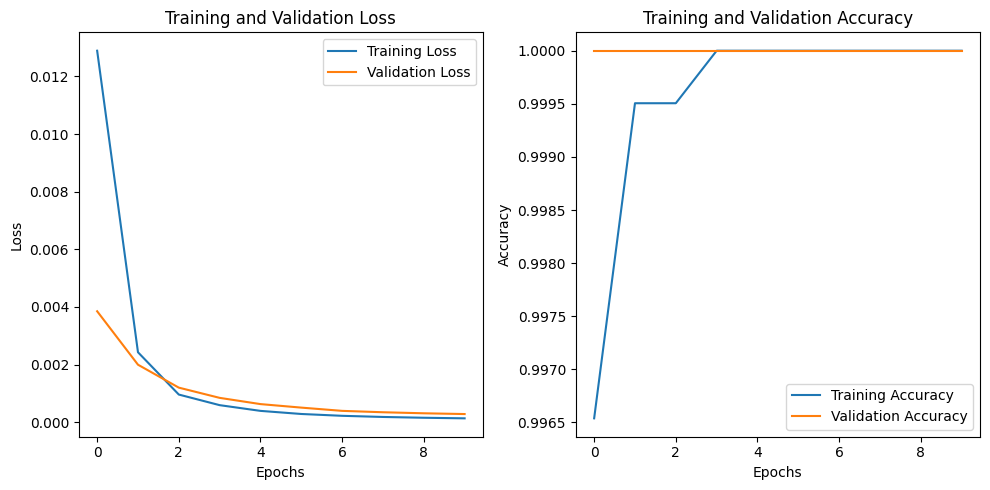

8/8 [==============================] - 2s 186ms/step - loss: 2.7989e-04 - accuracy: 1.0000
Fold: 4
Epoch 1/10
64/64 [==============================] - 26s 412ms/step - loss: 1.3377e-04 - accuracy: 1.0000 - val_loss: 8.9733e-05 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 27s 415ms/step - loss: 1.0597e-04 - accuracy: 1.0000 - val_loss: 8.1358e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 26s 414ms/step - loss: 9.3456e-05 - accuracy: 1.0000 - val_loss: 7.4889e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 27s 414ms/step - loss: 8.4171e-05 - accuracy: 1.0000 - val_loss: 6.9037e-05 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 414ms/step - loss: 7.4806e-05 - accuracy: 1.0000 - val_loss: 6.3951e-05 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 410ms/step - loss: 6.8412e-05 - accuracy: 1.0000 - val_loss: 5.9505e-05 - val_accuracy: 1.

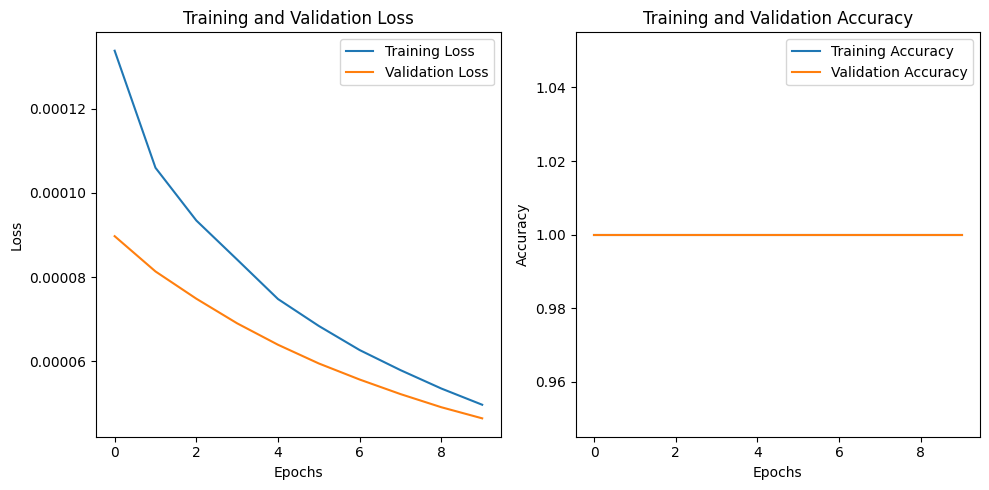

8/8 [==============================] - 1s 173ms/step - loss: 4.6480e-05 - accuracy: 1.0000
Fold: 5
Epoch 1/10
64/64 [==============================] - 26s 412ms/step - loss: 4.7514e-05 - accuracy: 1.0000 - val_loss: 3.3829e-05 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 27s 418ms/step - loss: 4.4196e-05 - accuracy: 1.0000 - val_loss: 3.2241e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 27s 415ms/step - loss: 4.1263e-05 - accuracy: 1.0000 - val_loss: 3.0929e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 27s 415ms/step - loss: 3.8654e-05 - accuracy: 1.0000 - val_loss: 3.0346e-05 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 403ms/step - loss: 3.6307e-05 - accuracy: 1.0000 - val_loss: 3.0577e-05 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 405ms/step - loss: 3.4150e-05 - accuracy: 1.0000 - val_loss: 3.0822e-05 - val_accuracy: 1.

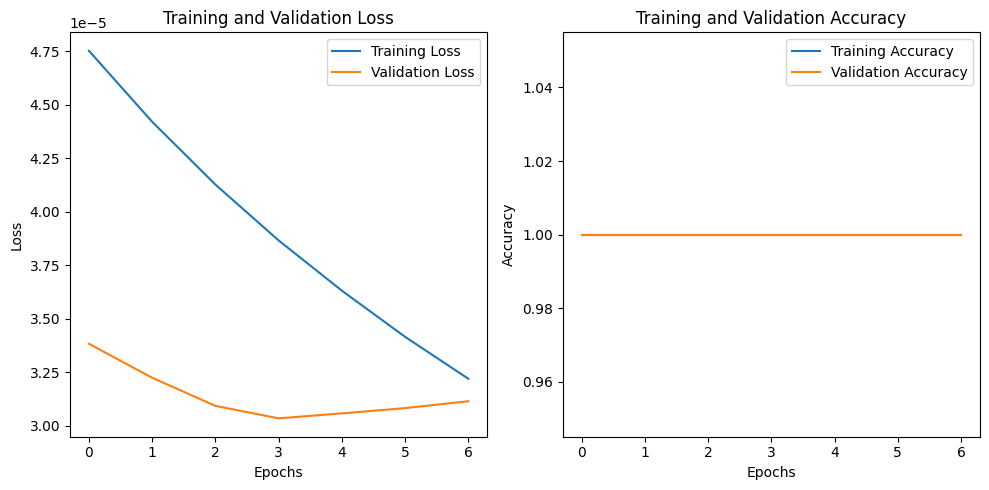

8/8 [==============================] - 2s 187ms/step - loss: 3.1145e-05 - accuracy: 1.0000
Fold: 6
Epoch 1/10
64/64 [==============================] - 26s 411ms/step - loss: 3.1379e-05 - accuracy: 1.0000 - val_loss: 2.1616e-05 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 26s 413ms/step - loss: 2.8972e-05 - accuracy: 1.0000 - val_loss: 2.0536e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 26s 414ms/step - loss: 2.7373e-05 - accuracy: 1.0000 - val_loss: 1.9544e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 26s 410ms/step - loss: 2.5928e-05 - accuracy: 1.0000 - val_loss: 1.8590e-05 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 410ms/step - loss: 2.4587e-05 - accuracy: 1.0000 - val_loss: 1.7704e-05 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 414ms/step - loss: 2.3338e-05 - accuracy: 1.0000 - val_loss: 1.6895e-05 - val_accuracy: 1.

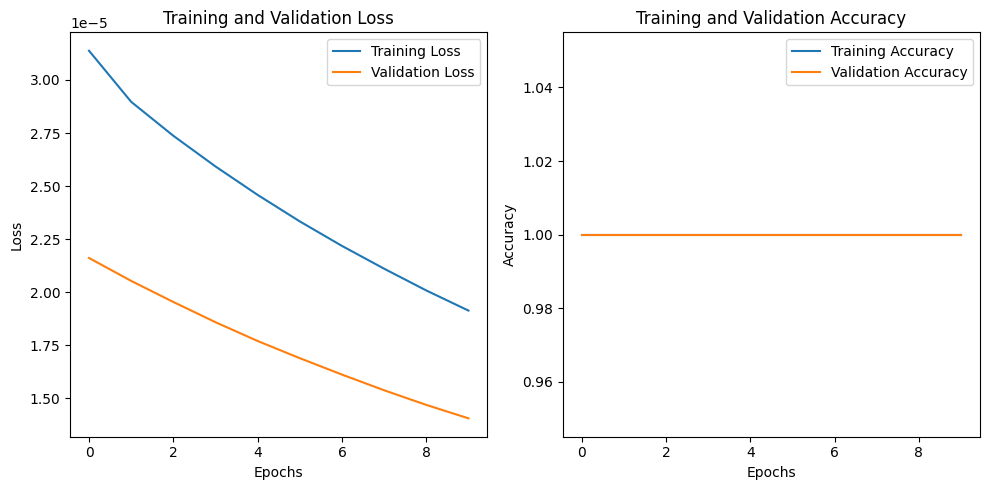

8/8 [==============================] - 2s 187ms/step - loss: 1.4061e-05 - accuracy: 1.0000
Fold: 7
Epoch 1/10
64/64 [==============================] - 27s 419ms/step - loss: 1.8009e-05 - accuracy: 1.0000 - val_loss: 1.5640e-05 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 27s 416ms/step - loss: 1.7183e-05 - accuracy: 1.0000 - val_loss: 1.5009e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 26s 411ms/step - loss: 1.6422e-05 - accuracy: 1.0000 - val_loss: 1.4448e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 26s 412ms/step - loss: 1.5701e-05 - accuracy: 1.0000 - val_loss: 1.3836e-05 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 413ms/step - loss: 1.5014e-05 - accuracy: 1.0000 - val_loss: 1.3310e-05 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 414ms/step - loss: 1.4366e-05 - accuracy: 1.0000 - val_loss: 1.2819e-05 - val_accuracy: 1.

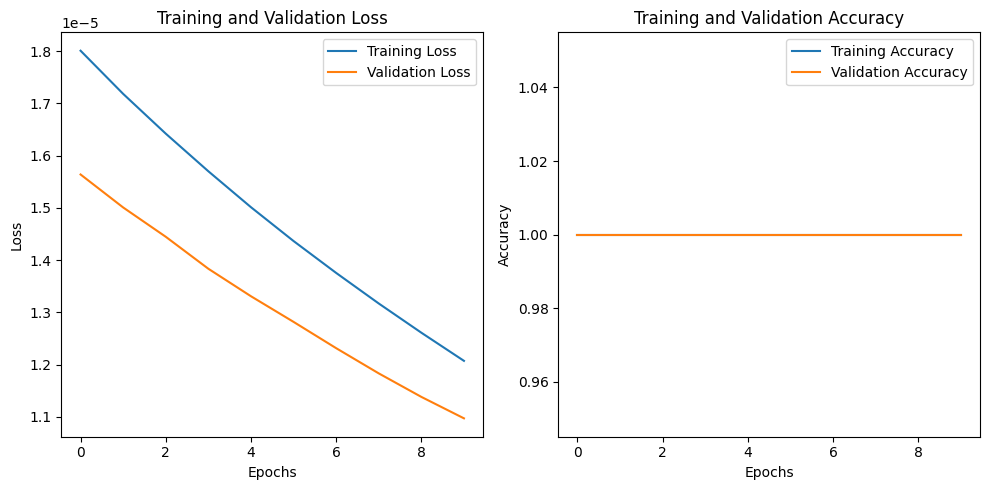

8/8 [==============================] - 2s 187ms/step - loss: 1.0973e-05 - accuracy: 1.0000
Fold: 8
Epoch 1/10
64/64 [==============================] - 27s 416ms/step - loss: 1.0792e-05 - accuracy: 1.0000 - val_loss: 1.7377e-05 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 26s 413ms/step - loss: 1.0371e-05 - accuracy: 1.0000 - val_loss: 1.6870e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 26s 409ms/step - loss: 9.9476e-06 - accuracy: 1.0000 - val_loss: 1.6386e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 26s 412ms/step - loss: 9.5628e-06 - accuracy: 1.0000 - val_loss: 1.5916e-05 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 409ms/step - loss: 9.2027e-06 - accuracy: 1.0000 - val_loss: 1.5477e-05 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 409ms/step - loss: 8.8376e-06 - accuracy: 1.0000 - val_loss: 1.4989e-05 - val_accuracy: 1.

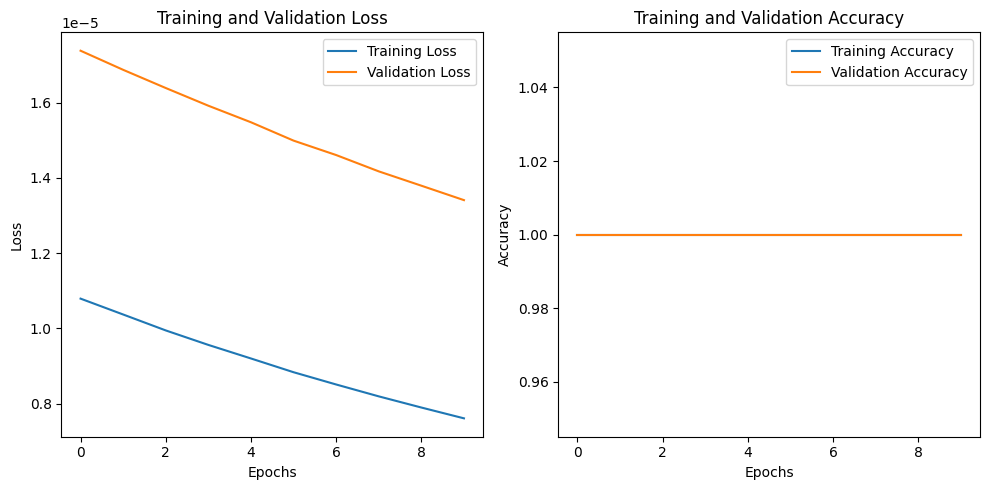

7/7 [==============================] - 1s 203ms/step - loss: 1.3409e-05 - accuracy: 1.0000
Fold: 9
Epoch 1/10
64/64 [==============================] - 27s 415ms/step - loss: 7.7982e-06 - accuracy: 1.0000 - val_loss: 8.9384e-06 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 26s 412ms/step - loss: 7.4924e-06 - accuracy: 1.0000 - val_loss: 8.6561e-06 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 26s 412ms/step - loss: 7.2024e-06 - accuracy: 1.0000 - val_loss: 8.3913e-06 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 26s 411ms/step - loss: 6.9256e-06 - accuracy: 1.0000 - val_loss: 8.1454e-06 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 413ms/step - loss: 6.6569e-06 - accuracy: 1.0000 - val_loss: 7.9004e-06 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 412ms/step - loss: 6.4104e-06 - accuracy: 1.0000 - val_loss: 7.6499e-06 - val_accuracy: 1.

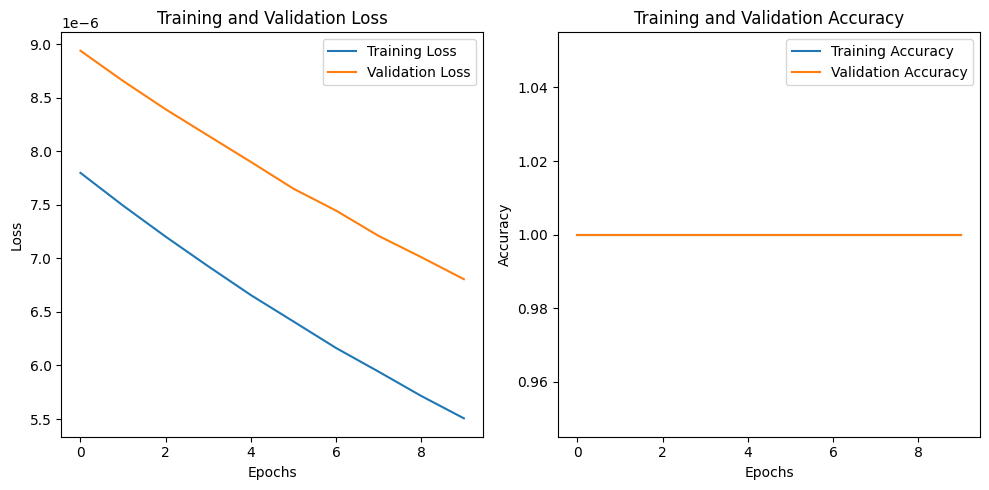

7/7 [==============================] - 1s 201ms/step - loss: 6.8053e-06 - accuracy: 1.0000
Fold: 10
Epoch 1/10
64/64 [==============================] - 27s 421ms/step - loss: 5.6117e-06 - accuracy: 1.0000 - val_loss: 3.5075e-06 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 27s 418ms/step - loss: 5.3311e-06 - accuracy: 1.0000 - val_loss: 3.3900e-06 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 27s 418ms/step - loss: 5.1282e-06 - accuracy: 1.0000 - val_loss: 3.2776e-06 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 27s 416ms/step - loss: 4.9418e-06 - accuracy: 1.0000 - val_loss: 3.1700e-06 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 26s 413ms/step - loss: 4.7594e-06 - accuracy: 1.0000 - val_loss: 3.0679e-06 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 26s 411ms/step - loss: 4.5863e-06 - accuracy: 1.0000 - val_loss: 2.9633e-06 - val_accuracy: 1

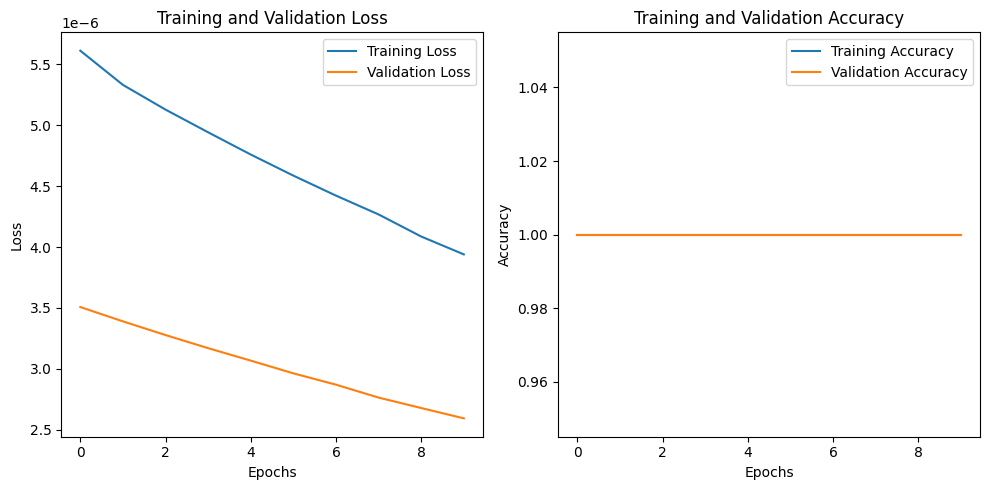

7/7 [==============================] - 1s 202ms/step - loss: 2.5941e-06 - accuracy: 1.0000
Accuracy for Fold 1: 0.9822221994400024
Accuracy for Fold 2: 0.9911110997200012
Accuracy for Fold 3: 1.0
Accuracy for Fold 4: 1.0
Accuracy for Fold 5: 1.0
Accuracy for Fold 6: 1.0
Accuracy for Fold 7: 1.0
Accuracy for Fold 8: 1.0
Accuracy for Fold 9: 1.0
Accuracy for Fold 10: 1.0
Average Accuracy: 0.9973333299160003
31/31 [==============================] - 6s 188ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       462
         1.0       0.98      0.97      0.98       501

    accuracy                           0.98       963
   macro avg       0.97      0.98      0.98       963
weighted avg       0.98      0.98      0.98       963

Confusion Matrix:
[[452  10]
 [ 14 487]]
44/44 [==============================] - 8s 189ms/step


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# Function to load files from a directory
def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as file_content:
                    file_text = file_content.read()
                file_list.append(file_text)
    return file_list
# Load training and test files for vulnerable and non-vulnerable classes
def load_data():
    dataset_dir = '/home/shaurya/BTP/1/Dataset/Code/C'
    vulnerable_dir = os.path.join(dataset_dir, 'Vulnerable')
    non_vulnerable_dir = os.path.join(dataset_dir, 'Non_vulnerable')

    vulnerable_train_files = load_files(os.path.join(vulnerable_dir, 'TRAIN'))
    vulnerable_test_files = load_files(os.path.join(vulnerable_dir, 'TEST'))
    non_vulnerable_train_files = load_files(os.path.join(non_vulnerable_dir, 'TRAIN'))
    non_vulnerable_test_files = load_files(os.path.join(non_vulnerable_dir, 'TEST'))

    train_codes = vulnerable_train_files + non_vulnerable_train_files
    test_codes = vulnerable_test_files + non_vulnerable_test_files

    labels = np.concatenate((np.ones(len(vulnerable_train_files)), np.zeros(len(non_vulnerable_train_files))), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(train_codes, labels, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, test_codes


def tokenize_sequences(X_train, X_test, test_codes):
    tokenizer = Tokenizer(num_words=359414, split=' ')
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    test_sequences = tokenizer.texts_to_sequences(test_codes)

    average_sequence_length = int(np.mean([len(seq) for seq in X_train_sequences]))

    X_train_padded = pad_sequences(X_train_sequences, maxlen=average_sequence_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=average_sequence_length)
    test_padded = pad_sequences(test_sequences, maxlen=average_sequence_length)

    return X_train_padded, X_test_padded, test_padded, tokenizer.word_index


def load_embedding_model():
    with open('/home/shaurya/BTP/1/Outputs/Embedding Models/FastText/fasttext_150_model.pkl', 'rb') as f:
        embedding_model = pickle.load(f)

    return embedding_model

def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='BLSTM_FT_EL'))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), name='BLSTM_FT_1'))
    model.add(Bidirectional(LSTM(units=128), name='BLSTM_FT_2'))
    model.add(Dense(units=1, activation='sigmoid', name='BLSTM_FT_OL'))
    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model

def perform_cross_validation(X_train_padded, y_train, model, skf):
    fold = 1
    accuracies = []

    for train_index, val_index in skf.split(X_train_padded, y_train):
        print(f"Fold: {fold}")
        fold += 1

        X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        checkpoint_path = f"/home/shaurya/BTP/1/Outputs/Checkpoints/Sentence/BILSTM/FastText/model10k_fold_{fold}.h5"
        checkpoint = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=False
        )

        history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop, checkpoint])
        
        plt.figure(figsize=(10, 5))  # Adjust figure size as desired
        plt.subplot(1, 2, 1)  # Create subplot for loss
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.subplot(1, 2, 2)  # Create subplot for accuracy
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

        _, accuracy = model.evaluate(X_val_fold, y_val_fold)
        accuracies.append(accuracy)

    return accuracies

def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)
    y_pred = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    print(report)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"/home/shaurya/BTP/1/Outputs/Checkpoints/Sentence/BILSTM/FastText/model10k_fold_{fold}.h5")


# Load the data
X_train, X_test, y_train, y_test, test_codes = load_data()

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)

# Load the Word2Vec embedding model
embedding_model = load_embedding_model()

# Create the embedding matrix
embedding_dim = 150
vocab_size = 359414
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size and word in embedding_model.wv:
        embedding_matrix[i] = embedding_model.wv[word]

# Create a sequential model
model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])

# Create an early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Create Stratified K-fold cross-validation object
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Perform cross-validation training and collect accuracies
accuracies = perform_cross_validation(X_train_padded, y_train, model, skf)

# Print accuracy for each fold
for fold, accuracy in enumerate(accuracies, start=1):
    print(f"Accuracy for Fold {fold}: {accuracy}")

# Calculate and print average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")

# Evaluate the model using the test set
evaluate_model(X_test_padded, y_test, model)

# Predict on the additional test set
test_pred = predict_additional_data(test_padded, model)

# Save the trained model for each fold
for fold in range(1, skf.n_splits + 1):
    save_model(model, fold)
    
    
model.save(f"/home/shaurya/BTP/1/Outputs/Models/LSTM/word2vec/BLSTM_ft.keras")
